In [1]:
import glob
import numpy as np
import scanpy as sc
from pcaeval.pca_eval import (evaluate_anndata_file_list, plot_sing_vals_exp_var,
 preprocess, process, evaluate_matrix, evaluate_anndata, print_dict_results)

In [2]:
sc.set_figure_params(dpi=80, dpi_save=150, format='tif', facecolor='white')

In [3]:
wd = '/home/davi/Bioinfo/PCA_distortion/'
adata_file = '/home/davi/Bioinfo/BenchmarkDatasets/data/PBMCs (68k).h5ad'

adata = sc.read_h5ad(adata_file)
adata

AnnData object with n_obs × n_vars = 68579 × 17789
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [4]:
adata_norm = adata.copy()

sc.pp.normalize_total(adata_norm, target_sum=1e4)
sc.pp.log1p(adata_norm)

adata_sc_250 = adata_norm.copy()
adata_sc_500 = adata_norm.copy()
adata_sc_1k = adata_norm.copy()
adata_sc_2k = adata_norm.copy()
adata_sc_3k = adata_norm.copy()
adata_sc_4k = adata_norm.copy()

adatas_sc_genes = [(adata_sc_250, 250), (adata_sc_500, 500), (adata_sc_1k, 1000), (adata_sc_2k, 2000), (adata_sc_3k, 3000), (adata_sc_4k, 4000)]
adatas_sc = []

for adat, n_genes in adatas_sc_genes:
    sc.pp.highly_variable_genes(adat, n_top_genes=n_genes)
    #sc.pl.highly_variable_genes(adat)
    adat.raw = adat
    adat = adat[:, adat.var.highly_variable]
    sc.pp.scale(adat, max_value=10)
    adatas_sc.append(adat)

/home/davi/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


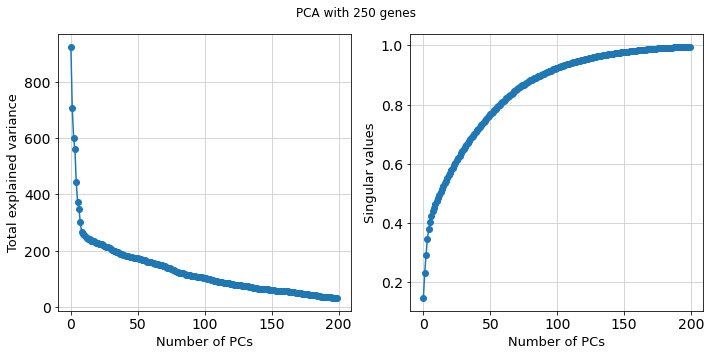

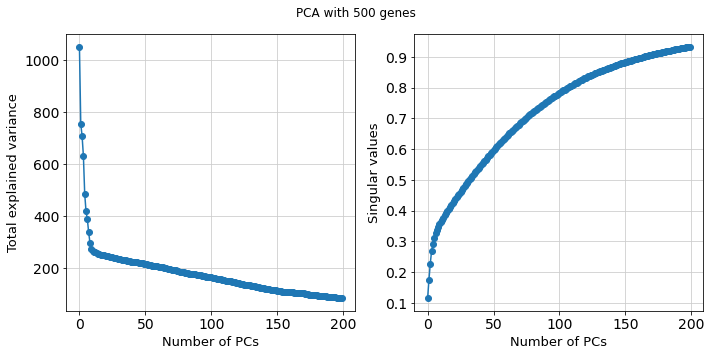

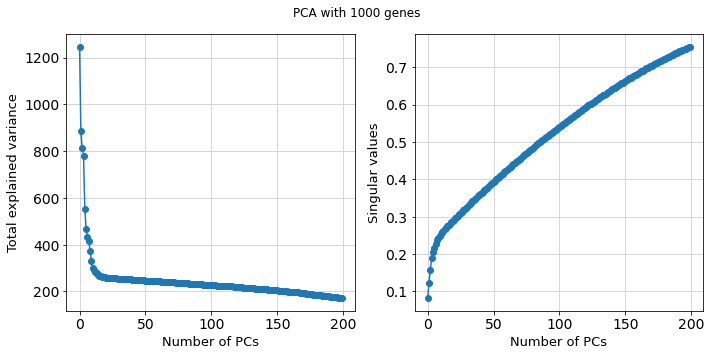

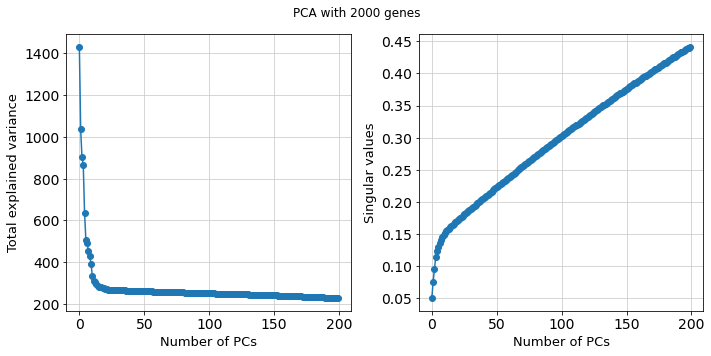

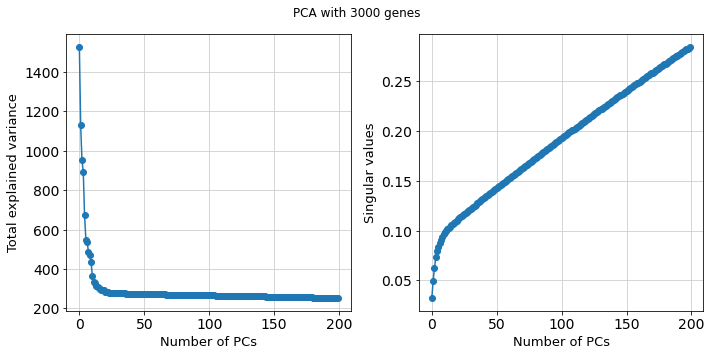

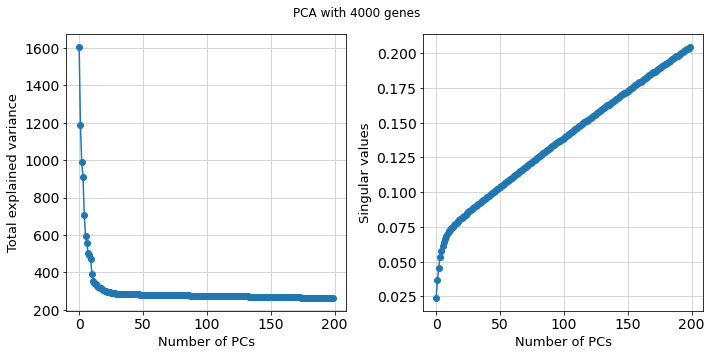

In [5]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from pcaeval.pca_eval import _plot_explained_variance, _plot_singular_values

pca = PCA(n_components=200)

for i in range(len(adatas_sc)):
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(left=0.2, right=0.98, bottom=0.001,
                    top=0.9, wspace=0.15, hspace=0.01)
    pca.fit(adatas_sc[i].X)
    plt.suptitle('PCA with {} genes'.format(adatas_sc_genes[i][1]))
    plt.subplot(1, 2, 1)
    _plot_explained_variance(pca.singular_values_, fontsize=13)
    plt.subplot(1, 2, 2)
    _plot_singular_values(pca.explained_variance_ratio_.cumsum(), fontsize=13)
    plt.tight_layout()
    plt.show()

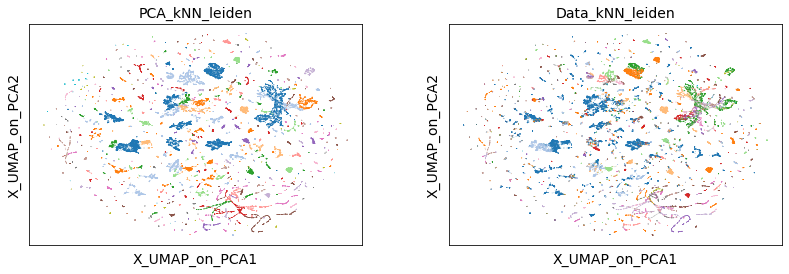

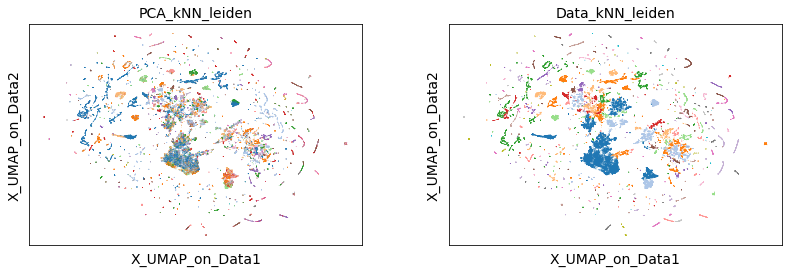

KeyboardInterrupt: 

In [6]:
for adat in adatas_sc:
    adat = process(adat, n_pcs=200)
    sc.pl.embedding(adat, basis='X_UMAP_on_PCA', color=['PCA_kNN_leiden', 'Data_kNN_leiden'], palette='tab20', legend_loc=None)
    sc.pl.embedding(adat, basis='X_UMAP_on_Data', color=['PCA_kNN_leiden', 'Data_kNN_leiden'], palette='tab20', legend_loc=None)

In [ ]:
for i in range(len(adatas_sc)):
    adat = adatas_sc[i]
    sc.tl.rank_genes_groups(adat, groupby='PCA_kNN_leiden', use_raw=True, pts=True, n_genes=adat.raw.to_adata().shape[1], method='logreg')
    sc.pl.rank_genes_groups_dotplot(adat, groupby='PCA_kNN_leiden', n_genes=1, vmin=0, vmax=3, cmap='plasma', swap_axes=True, save='pbmc68k_pca_markers_logreg_' + str(adatas_sc_genes[i][1]) + '_genes')

In [ ]:
for adat in adatas_sc:
    sc.tl.rank_genes_groups(adat, groupby='Data_kNN_leiden', use_raw=True, pts=True, n_genes=adat.raw.to_adata().shape[1], method='logreg')
    sc.pl.rank_genes_groups_dotplot(adat, groupby='Data_kNN_leiden', n_genes=1, vmin=0, vmax=3, cmap='plasma', swap_axes=True, save='pbmc68k_data_markers_logreg' + str(adatas_sc_genes[i][1]) + '_genes')

In [ ]:
from scipy.spatial.distance import pdist, squareform
euc_knn_dists = []
for i in range(len(adatas_sc)):
    euc_knn_dists.append(ld_pdists=squareform(pdist(adatas_sc[i].X)))

dists = ((euc_knn_dists[0], 'Pairwise distances (m=250 genes)'),
         (euc_knn_dists[1], 'Pairwise distances (m=500 genes)'),
         (euc_knn_dists[2], 'Pairwise distances (m=1000 genes)'),
         (euc_knn_dists[3], 'Pairwise distances (m=2000 genes)'),
         (euc_knn_dists[4], 'Pairwise distances (m=3000 genes)'),
         (euc_knn_dists[5], 'Pairwise distances (m=4000 genes)'))


fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
i = 1
ax1, ax2, ax3, ax4, ax5, ax6 = axes
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(dists)):
    ax = axs[i]
    dist, title = dists[i]
    ax.hist(dist.flatten(), bins=200, density=True, histtype='step', lw=2)
    ax.set_title(title)
    ax.xaxis_inverted()
    ax.set_xlabel('Euclidean distance')
    ax.set_ylabel('Density')
    i += 1

fig.tight_layout()

In [ ]:
total_dict = {}
for i in range(len(adatas_sc)):
    n_genes = adatas_sc_genes[i][1]
    res_dict, adatas_sc[i] = evaluate_anndata(adatas_sc[i], preprocessed=True, n_jobs=-1)
    total_dict['m = '+ str(n_genes) + ' HVGs'] = res_dict

def_dict, adata = evaluate_anndata(adata, n_pcs=200, n_jobs=-1)

dict_print = {'PBMC68K':res_dict}
print_dict_results(dict_print)

In [ ]:
# Now using only 50 PCs
for adat in adatas_sc:
    adat = process(adat, n_pcs=50)
    sc.pl.embedding(adat, basis='X_UMAP_on_PCA', color=['PCA_kNN_leiden', 'Data_kNN_leiden'], palette='tab20', legend_loc=None)
    sc.pl.embedding(adat, basis='X_UMAP_on_Data', color=['PCA_kNN_leiden', 'Data_kNN_leiden'], palette='tab20', legend_loc=None)